## Merge two granules using pyresample

this note book takes two 5 minute modis granules and combines then into 1 image

In [1]:
%matplotlib inline

In [2]:
# %load temp.py


# ### Objective -- move center of image from Seattle to UBC 
# 
# We want to take an image centered on Seattle and move the image center to UBC

# In[1]:

from e582utils.data_read import download

import numpy as np
import h5py
import warnings
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
import seaborn as sns
from e582lib.modis_chans import chan_dict
from e582lib.channels_reproject import subsample,find_corners
from e582lib.channels_reproject import resample_channels
from e582lib.map_slices import get_corners_centered, make_basemap_xy,make_xy
import pyproj
from affine import Affine
from rasterio.warp import calculate_default_transform
from rasterio.warp import reproject, Resampling
warnings.filterwarnings("ignore")
from pyresample import kd_tree, geometry
import pyresample

### convenience function to get col,row from lon,lat

### now set up a basemap plot  

note that we have the affine transform for the pyresample reprojection,
so we are free to change the lat/lon corners of the plot to whatever
looks good and basemap will be able to figure out the project coordinates
and clip the image

In [15]:
height, width=ndvi.shape
ll_x,ll_y = transform*(0,height)
ur_x,ur_y = transform*(width,0)
lon_0,lat_0 = projection(0,0,inverse=True)
ll_lon,ll_lat = projection(ll_x,ll_y,inverse=True)
ur_lon,ur_lat = projection(ur_x,ur_y,inverse=True)
ll_lon,ll_lat= -130,17
ur_lon,ur_lat = -90,54
ll_dict=dict(llcrnrlat=ll_lat,llcrnrlon=ll_lon,urcrnrlat=ur_lat,
              urcrnrlon=ur_lon,lon_0=lon_0,lat_0=lat_0)


basemap_args = dict()
basemap_args['ellps'] = projection_dict['datum']
basemap_args.update(ll_dict)
basemap_args['projection'] = projection_dict['proj']
basemap_args['lat_0'] = projection_dict['lat_0']
basemap_args['lon_0'] = projection_dict['lon_0']

basemap_args['resolution']='c'
bmap=Basemap(**basemap_args)

### use basemap to get projection x,y values, and plot using ax.pcolormesh

note the easting and northing (x_0, y_0) that basemap adds to the coordinates

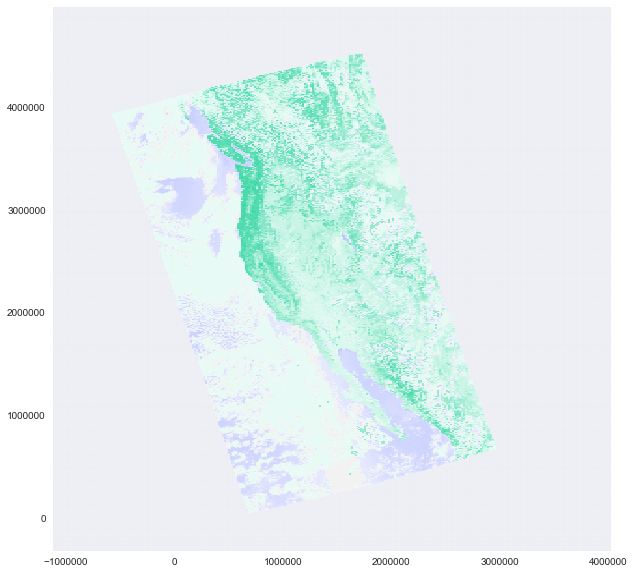

In [16]:
ndvi_masked=np.ma.masked_invalid(ndvi)
ur_row=0
ll_row=height
ll_col=0
ur_col=width
xvals,yvals = make_basemap_xy(ur_row,ll_row,ll_col,ur_col,bmap,transform)

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.pcolormesh(xvals,yvals,ndvi_masked,cmap=cmap,norm=the_norm);

### Finally, use basemap.pcolormesh to replot

note that basemap changes the aspect ratio

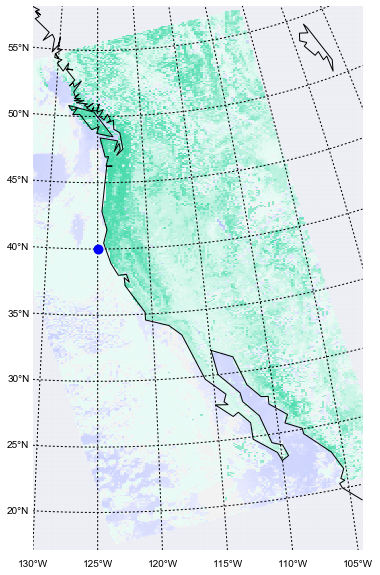

In [17]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
basemap_args['ax']=ax
bmap=Basemap(**basemap_args)
bmap.pcolormesh(xvals,yvals,ndvi_masked,cmap=cmap,norm=the_norm)
bmap.drawcoastlines()
lat_sep,lon_sep= 5, 5
parallels = np.arange(10, 60, lat_sep)
meridians = np.arange(-150,-90, lon_sep)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],
                        fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],
                       fontsize=10, latmax=90);
x0,y0=bmap(lon_0,lat_0)
bmap.plot(x0,y0,'bo',markersize=10);

In [19]:
### write h5 file
from e582lib.map_slices import write_h5
write_h5(out_file='stitched_out.h5',affine_transform=transform,
         channels=stitched_chans,
         projection_dict=projection_dict,
         fill_value=nan_fill_value,
         chan_list=chan_list,
         comments='written by merge_modis notebook')

inside write_h5: channels shape=  (500, 300, 5)
